In [1]:
"""
Today we will look at ensemble learning, which is an often undervalued part of machine learning. The way it works is
by taking multiple different classifiers, training them, and then averaging their predictions into one "ensemble" prediction. 
You often want to have a diverse set of classifiers so you can aggregate predictions. The reason this works is because even if you havesubpar classifiers with a 60% chance of predicting correctly on their own - as a group together it will increase more 
and more as long as these classifiers all have different learnt parameters. This can be suprisingly effective. 
The two algorithms we will look at are Random Forests and Ensemble Classifiers. 
"""

#let's get started
import sealion as sl 
from sealion.ensemble_learning import RandomForest, EnsembleClassifier

In [2]:
"""
Random Forests are just a collection of decision trees that's predictions are aggregated. The way this works
is by having each decision tree trained on a different set of data - so you can have a diverse set of trees that's predictions
will then be averaged and given to the user. Each tree was trained on a different set of data, so they won't be the same. We also 
have some added functionality as well which you will see in a bit. We are going to use the titanic dataset with the 
same preprocessing steps as the decision trees examples, so feel free to skip down until this "X_train, X_test = new_X_train, new_X_test" cell.
These random forests can be trained in parallel on multiple CPU cores, which is exactly what SeaLion does. 
"""

import pandas as pd
# first we can load in the dataset
titanic_dataframe = pd.read_csv("titanic_dataset.csv") # of my local computer
titanic_dataframe # print it out

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# looks like it has 891 rows and 12 columns. First we can delete some of the features we know we won't use. 
titanic_dataframe = titanic_dataframe.drop(['Name', 'Ticket', 'Cabin'], axis = 1) # non-numeric
titanic_dataframe = titanic_dataframe.fillna(0)

In [4]:
# next we can change the sex column. Female will be 0 and Male will be 1. 
import numpy as np # we'll need this too
sex_col = np.array(titanic_dataframe['Sex'])
sex_col[np.where(sex_col == "male")] = 0
sex_col[np.where(sex_col == "female")] = 1
titanic_dataframe["Sex"]  = sex_col

# we can also change the embarked column - we will make it one-hot-encoded
from sealion.utils import one_hot
embarked_col = np.array(titanic_dataframe["Embarked"])
embarked_col[np.where(embarked_col == "S")] = 0
embarked_col[np.where(embarked_col == "C")] = 1
embarked_col[np.where(embarked_col == "Q")] = 2 
titanic_dataframe["Embarked"] = embarked_col
titanic_dataframe

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,0
887,888,1,1,1,19.0,0,0,30.0000,0
888,889,0,3,1,0.0,1,2,23.4500,0
889,890,1,1,0,26.0,0,0,30.0000,1


In [5]:
# looks like we are all set. Time to get the labels and the training and testing data
y = np.array(titanic_dataframe['Survived'])
titanic_dataframe = titanic_dataframe.drop('Survived', axis = 1)
X = np.array(titanic_dataframe)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [6]:
#we'll need to one_hot_encode the last column of X_train and X_test (Embarked)
embarked_train = one_hot(X_train[:, -1], depth = 3)
embarked_test = one_hot(X_test[:, -1], depth = 3)

In [7]:
# we'll have to use a bit of the long route to avoid typical rules of numpy
new_X_train, new_X_test = [], []
X_train, X_test = np.array(X_train).tolist(), np.array(X_test).tolist() # turn them into regular python lists
for row in range(len(X_train)) : 
    observation = X_train[row] # get the row
    observation[-1] = embarked_train[row].tolist() # .tolist() helps make sure it can be interpreted (only needed as of v3.0.8 if you are using one_hot_encoded data) 
    new_X_train.append(observation)
    
for row in range(len(X_test)) : 
    observation = X_test[row] # get the row
    observation[-1] = embarked_test[row].tolist()
    new_X_test.append(observation)

In [8]:
X_train, X_test = new_X_train, new_X_test # just change the name

In [25]:
# yay now we have our data. We can now apply the random forest algorithm.  

rf = RandomForest(num_classifiers = 20,  replacement = True, min_data = 50)

# a quick word on the arguments
# num_classifiers is just the amount of trees to be made
# max_branches and min_samples are the same arguments as in decision trees
# replacement is whether or not to boostrap. When deciding the dataset for each of the 20 trees, you may 
# want to not have any data points shared across the datasets or be fine with some. In general using bootstrapping
# does better on testing data at the expense of training data. 
# min_data is simply the minimum amount of data points you need each set to have. If you set replacement = True, 
# then what will happen is that each decision tree will get a different amount of data, one may get 5 samples and 
# another may get 500. So if you want to ensure that at least all datasets get some X amount of data you can set that there. 

rf.fit(X_train, y_train) # let's train it!

Validation accuracy :  0.96


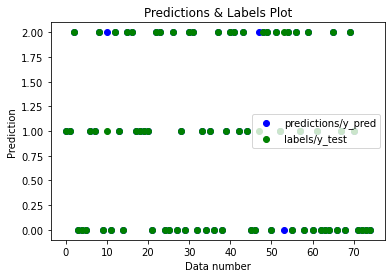

In [28]:
# as usual we'll want to evaluate it and visualize its evaluation
print("Validation accuracy : ", rf.evaluate(X_test, y_test))
rf.visualize_evaluation(rf.predict(X_test), y_test)

In [29]:
# 96% accuracy is really good compared to what we were getting before with a decision tree (78%) 
# but here's where the cool part comes in!

# You know - I bet you that one of those trees in the random forests is better than all of them, so 
# why don't we just go find that tree, get it, and then use it? Seriously. 

from sealion.decision_trees import DecisionTree
best_tree = rf.give_best_tree(X_test, y_test) # get the best tree of off the data you give it
dt = DecisionTree()
dt.give_tree(best_tree) # enter the best tree trained from the random forests
dt.evaluate(X_test, y_test) # see how well that best tree in random forests did

0.9733333333333334

In [18]:
#WOW! 97%? Moving from 96% to 97% is a big deal - it gets exponentially harder to make the model near perfect. 

# That's mostly it for random forests. Onto ensemble classifiers!
# the way ensemble classifiers work is super simple. All it does is just take in a bunch of predictors, 
# train all of them, and then average all of their predictions. It's basically a random forest but for other classifiers. 

# for this we can use the blobs dataset 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
X, y = make_blobs(500, random_state = 2, centers = 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 3)

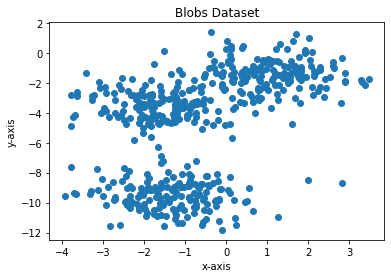

In [19]:
# as usual we can visualize our dataset
import matplotlib.pyplot as plt
fig = plt.figure() 
ax = fig.add_subplot()
ax.scatter(X[:, 0], X[:, 1])
plt.title("Blobs Dataset")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.show()

In [20]:
# well the first thing we have to do is setup our classifiers. We are going to be using k-nearest-neighbors, 
# gaussian naive bayes, and a decision tree.

from sealion.naive_bayes import GaussianNaiveBayes
from sealion.nearest_neighbors import KNearestNeighbors

knn = KNearestNeighbors(k = 5) 
gnb = GaussianNaiveBayes()
dt = DecisionTree(min_samples = 5, max_branches = 25)

In [30]:
# then we can setup our classifiers dict

classifiers_dict = {"k-nearest-neighbors" : knn, "gaussian_nb" : gnb, "decision_trees" : dt} # give a name to each of your classifiers

ec = EnsembleClassifier(classifiers_dict, classification = True) # set it up (note : can't use this for neural nets)

# classification = True because we are using classification, but set it False for regression. The default is True,
# and an easy way to remember this is because its an EnsembleCLASSifier. 

ec.fit(X_train, y_train) # we can now train the all classifiers - will train all algos on all CPU cores available in parallel

In [31]:
# well .... let's evaluate it
ec.evaluate(X_test, y_test)

0.9866666666666667

In [32]:
# looks like it did well, but even at the top there's a hierarchy. Let's see which one did best. 
ec.evaluate_all_predictors(X_test, y_test)

k-nearest-neighbors : 0.9866666666666667
gaussian_nb : 0.9866666793823242
decision_trees : 0.9733333333333334


In [27]:
# Looks like its the Gaussian Naive Bayes (I was expecting the KNN to do best)
# we could also just get that class like : 

best_predictor = ec.get_best_predictor(X_test, y_test)
print(best_predictor)

# and we can use it...
y_pred = best_predictor.predict(X_test)
y_pred == y_test # ... do more things ... 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [ ]:
# well why is this useful? Well for one thing imagine if you knew you were going to use a KNN but wasn't sure
# about the k-value. Well you could just add multiple KNN classes here - all w/ different k-values - and just 
# get the class that works best and use it. That way hyperparameter tuning is a breeze.  
# That too this module trains algorithms extremely fast, so you could take advantage of that. 

# If you think you have a better way to use it, please let me know @anish.lakkapragada@gmail.com or on GitHub. 
# In the meantime, thank you!